In [1]:
import numpy as np
import scanpy as sc
import pandas as pd 
import anndata
import json

In [2]:
adata = anndata.read_h5ad('../data/sc_reference.h5ad')
adata.obs.rctd_cluster -= 1
adata.obs.rctd_cluster = adata.obs.rctd_cluster.astype('category')
adata

AnnData object with n_obs × n_vars = 16679 × 16960
    obs: 'rctd_cluster'

In [3]:
n_top_genes = 10000
min_cells = 10
min_counts = 10

adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)
sc.pp.filter_cells(adata, min_counts=min_counts)
adata = adata[adata.obs["pct_counts_mt"] < 20].copy()
adata = adata[:, ~adata.var["mt"]]
sc.pp.filter_genes(adata, min_cells=min_cells)

adata.layers["raw_count"] = adata.X

sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(
    adata, flavor="seurat", n_top_genes=n_top_genes)

adata = adata[:, adata.var.highly_variable]
adata

/ix/djishnu/alw399/envs/bee/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:275: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


View of AnnData object with n_obs × n_vars = 16679 × 10000
    obs: 'rctd_cluster', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'raw_count'

In [4]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 4, 4
sc.set_figure_params(dpi=80, color_map='viridis')

In [5]:
genes = adata.to_df().columns
len(genes)

10000

In [6]:
import itertools 

marker_genes_dict = {
    'Naive': ['Cd44'],
    'Tfh': ['Bcl6', 'Cxcr5', 'Pdcd1', 'Icos'],
    'Th2': ['Gata3', 'Il4', 'Prdm1', 'Stat6', 'Il2ra', 'Gata3'],
    'Th1': ['Tbx21', 'Ifng'],
    'B-cell': ['Cd79a', 'Ms4a1'],
    'T-cell': ['Ptprc', 'Rpsa', 'Ccr7', 'Cd8a', 'Cd4'],
    'Dendritic': ['Cd24a', 'Cd40', 'Cd80', 'Cd86', 'Batf3'],
    'Treg': ['Foxp3'],
    'NK': ['Nkg7'],
    'Myeloid': ['Cst3'],
    }

marker_genes = list(itertools.chain(*marker_genes_dict.values()))
filtered_markers = [g for g in marker_genes if g in genes]

len(filtered_markers), len(marker_genes)

(26, 28)

In [7]:
# ax = sc.pl.dotplot(adata, var_names=filtered_markers, groupby='rctd_cluster')
ax = sc.pl.dotplot(adata, marker_genes_dict, groupby='rctd_cluster')

KeyError: "Could not find keys '['Cd80', 'Pdcd1']' in columns of `adata.obs` or in adata.var_names."

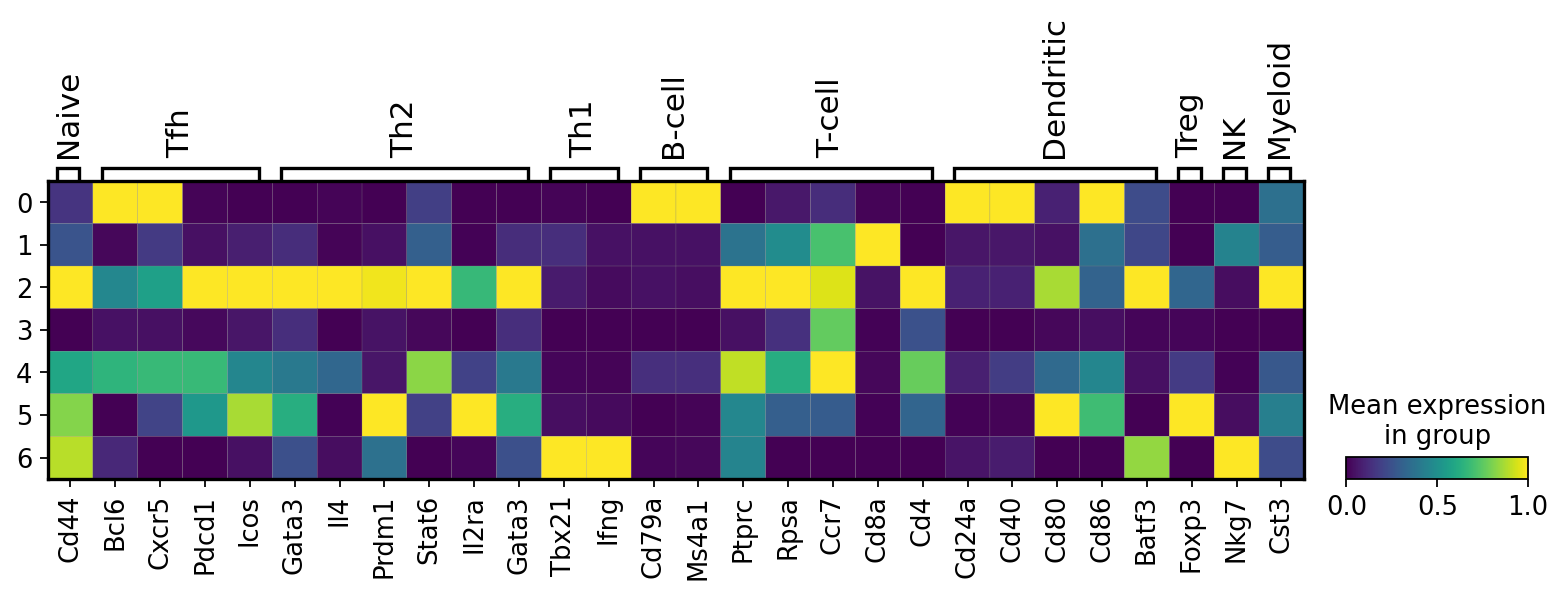

In [ ]:
gs = sc.pl.matrixplot(adata, marker_genes_dict, groupby='rctd_cluster', dendrogram=False, standard_scale='var')

In [ ]:
celltype_assign = {
    0: 'B-cell',
    1: 'Cd8 T-cell',
    2: 'Tfh',
    3: 'Naive',
    4: 'Tfh',
    5: 'Treg',
    6: 'Th1'
}

with open ('../data/celltype_assign.json', 'w') as f:
    json.dump(celltype_assign, f)